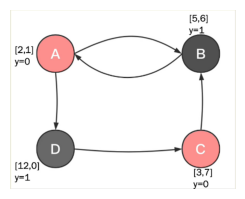

In [35]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg
img1 = mpimg.imread('./images/graph.png')
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.show()

In [36]:
import torch
from torch_geometric.data import Data

x = torch.tensor([[2,1],[5,6],[12,0],[3,7]],dtype=torch.float)
y = torch.tensor([0,1,0,1],dtype=torch.float)

edge_index = torch.tensor([[0,1,0,2,3],
                           [1,0,3,1,2]],dtype=torch.long)

data = Data(x=x, y=y, edge_index=edge_index)

In [2]:
data

Data(x=[4, 2], edge_index=[2, 5], y=[4])

In [44]:
print('data.num_nodes =',data.num_nodes)
print('data.num_node_features =',data.num_node_features)

data.num_nodes = 4
data.num_node_features = 2


In [45]:
print('data.num_edges =',data.num_edges)
print('data.num_edge_features =',data.num_edge_features)

data.num_edges = 5
data.num_edge_features = 0


In [50]:
print(data.has_isolated_nodes())
print(data.has_self_loops())
print(data.is_directed())
print(data.keys)

False
False
True
['y', 'edge_index', 'x']


In [54]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

data = dataset[0]
print(data)
print(data.is_undirected())

600
6
3
Data(edge_index=[2, 168], x=[37, 3], y=[1])
True


In [58]:
dataset = dataset.shuffle()
print(dataset.shuffle())

ENZYMES(600)


In [60]:
perm = torch.randperm(len(dataset))
dataset = dataset[perm]
print(dataset[perm])

ENZYMES(600)


In [62]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Using existing file ind.cora.x
Using existing file ind.cora.tx
Processing...
Done!


In [64]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x= self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [76]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8000
